### Stage 3: FitnessGroup multiclass classification

In [231]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

### 1. Data Preprocessing

#### 1.1. Data Loading

In [232]:
FitBit_data = pd.read_csv("FitBit_clustered_data.csv")
FitBit_data

,Id,Day,Calories,Steps,TotalMinutesAsleep,IntensityGroup,FitnessGroup
0,1503960366,2016-04-12,1985,13162,327.0,1,3
1,1503960366,2016-04-13,1797,10735,384.0,1,3
2,1503960366,2016-04-15,1745,9762,412.0,0,3
3,1503960366,2016-04-16,1863,12669,340.0,1,3
4,1503960366,2016-04-17,1728,9705,700.0,1,2
...,...,...,...,...,...,...,...
408,8792009665,2016-04-30,2896,7174,343.0,0,1
409,8792009665,2016-05-01,1962,1619,503.0,0,2
410,8792009665,2016-05-02,2015,1831,415.0,0,2
411,8792009665,2016-05-03,2297,2421,516.0,0,2


In [233]:
FitBit_data.describe()

,Id,Calories,Steps,TotalMinutesAsleep,IntensityGroup,FitnessGroup
count,4.130000e+02,413.000000,413.000000,413.000000,413.000000,413.000000
mean,5.000979e+09,2397.573850,8541.140436,419.467312,0.375303,1.857143
std,2.060360e+09,762.886326,4156.926990,118.344679,0.484788,0.922443
min,1.503960e+09,257.000000,17.000000,58.000000,0.000000,0.000000
25%,3.977334e+09,1850.000000,5206.000000,361.000000,0.000000,1.000000
50%,4.702922e+09,2220.000000,8925.000000,433.000000,0.000000,2.000000
75%,6.962181e+09,2926.000000,11393.000000,490.000000,1.000000,3.000000
max,8.792010e+09,4900.000000,22770.000000,796.000000,1.000000,3.000000


#### 1.2. Select Target and Features

In [234]:
x_unscaled = FitBit_data[["Calories", "Steps", "TotalMinutesAsleep"]] # Select features
y = np.array(FitBit_data[["FitnessGroup"]]).ravel() # Select target

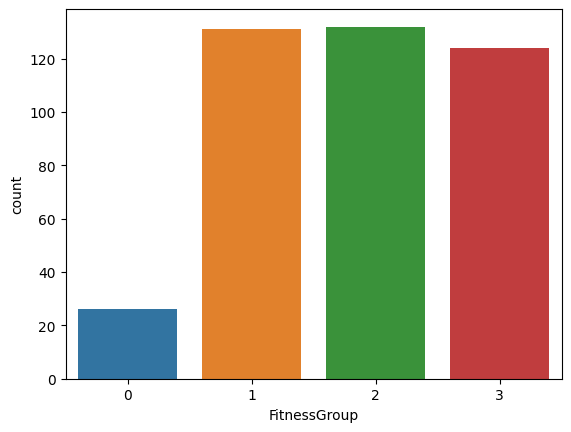

In [235]:
sns.countplot(x=FitBit_data["FitnessGroup"], label="Count")
plt.show()

#### 1.3. Data Scaling

Feature scaling in Machine Learning is a method used to normalize the range of independent variables or features of data. Gradient descent and distance-based algorithms are heavily impacted by the range of features.

In [236]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your data
x = pd.DataFrame(scaler.fit_transform(x_unscaled), columns=x_unscaled.columns)

In [237]:
# Save the scaler in order to use it in external application
joblib.dump(scaler, "scaler_classification.joblib")

# How to use it later: load the scaler from the file
loaded_scaler = joblib.load("scaler_classification.joblib")

input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the loaded scaler to transform new data
output_data = pd.DataFrame(loaded_scaler.transform(input_data), columns=input_data.columns)
output_data

,Calories,Steps,TotalMinutesAsleep
0,-0.788194,0.5284,-0.300059


#### 1.4. Train Test Split

In [238]:
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### 2. Classification Metric: [Multiclass Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

ROC curves are typically used in binary classification, where the TPR and FPR can be defined unambiguously. In the case of multiclass classification, a notion of TPR or FPR is obtained only after binarizing the output. This can be done in 2 different ways:
- the One-vs-Rest scheme compares each class against all the others (assumed as one);
- the One-vs-One scheme compares every unique pairwise combination of classes.

Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics as follows:

Obtaining the macro-average requires computing the metric independently for each class and then taking the average over them, hence treating all classes equally a priori. We first aggregate the true/false positive rates per class.

> In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging.

In [239]:
def OvR_micro_averaged_ROC_curve(fitted_classifier, x_test, y_test, classes):
    # Get decision function scores
    y_score = fitted_classifier.predict_proba(x_test)

    # Binarize the labels
    y_test_bin = label_binarize(y_test, classes=classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return roc_auc, fpr, tpr

### 3. Classification Step

#### 3.1. KNN Classifier

##### 3.1.1. Adjusting k parameter

Best k parameter: 5


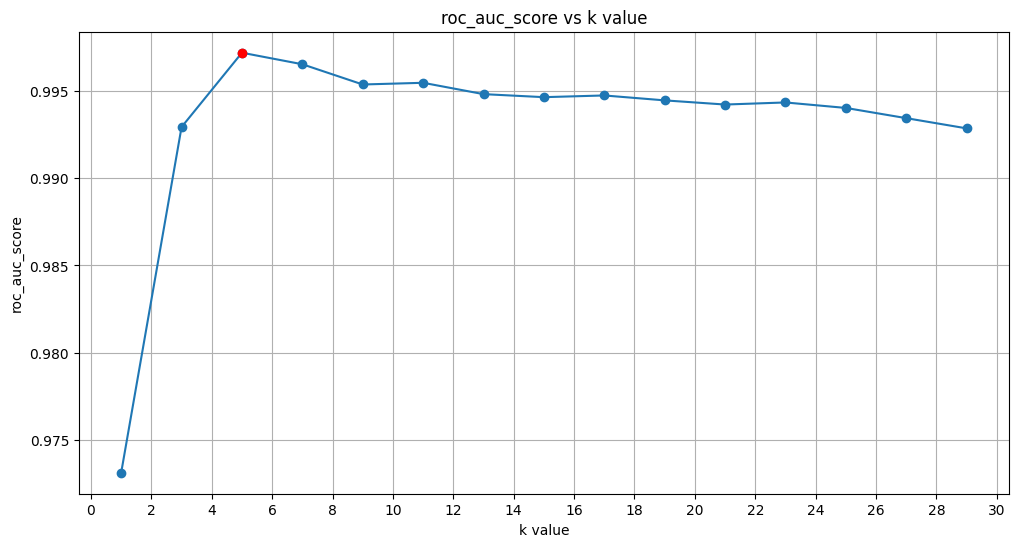

In [240]:
knn_roc_auc_score = []

for k in range(1,30,2):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(x_train,y_train)

    roc_auc, fpr, tpr = OvR_micro_averaged_ROC_curve(knn_classifier, x_test, y_test, np.unique(y))
    knn_roc_auc_score.append(roc_auc["micro"])

best_k_parameter = np.argmax(knn_roc_auc_score)*2 + 1
print("Best k parameter:", best_k_parameter)

plt.figure(figsize=(12,6))
plt.plot(range(1,30,2), knn_roc_auc_score, marker="o")
plt.plot(best_k_parameter, knn_roc_auc_score[np.argmax(knn_roc_auc_score)], "o", c="red")
plt.locator_params(axis="x", nbins=30) 
plt.title("roc_auc_score vs k value")
plt.xlabel("k value")
plt.ylabel("roc_auc_score")
plt.grid()

##### 3.1.2. Conducting the KNN Classification

In [241]:
knn_classifier = KNeighborsClassifier(n_neighbors=best_k_parameter).fit(x_train,y_train)

##### 3.1.3. KNN ROC-curve

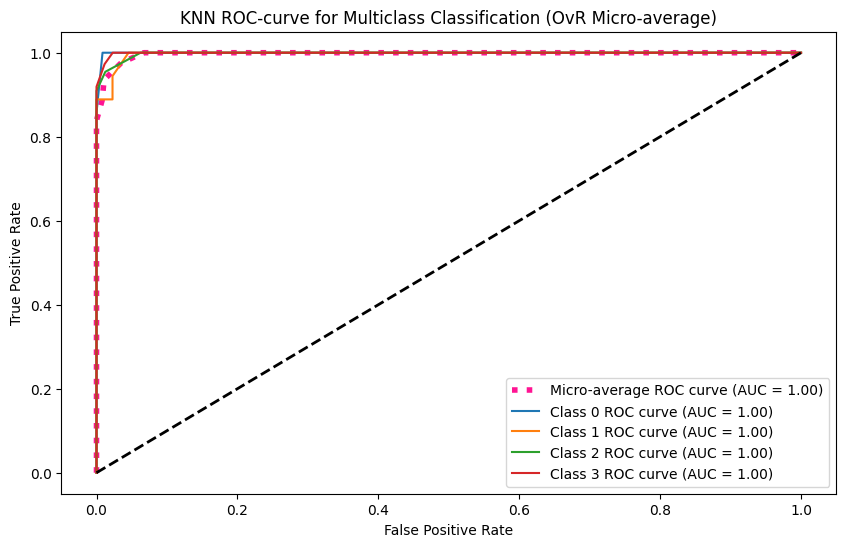

In [242]:
roc_auc, fpr, tpr = OvR_micro_averaged_ROC_curve(knn_classifier, x_test, y_test, np.unique(y))
knn_roc_auc_score = roc_auc["micro"]

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color="deeppink", linestyle=":", linewidth=4)

for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC-curve for Multiclass Classification (OvR Micro-average)")
plt.legend(loc="lower right")
plt.show()

##### 3.1.4. Confusion Matrix

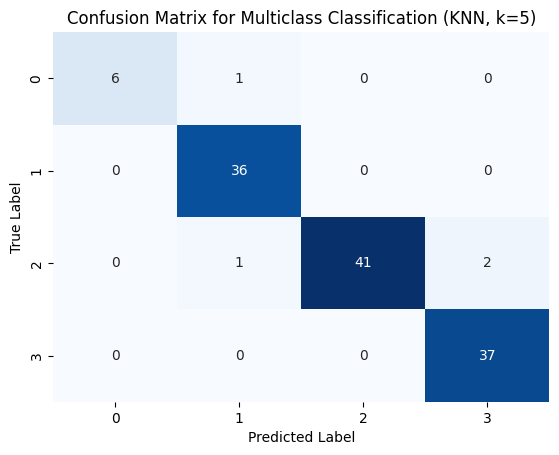

In [243]:
knn_confusion_matrix = confusion_matrix(y_test, knn_classifier.predict(x_test))

# Plot the confusion matrix using seaborn
sns.heatmap(knn_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for Multiclass Classification (KNN, k={best_k_parameter})")
plt.show()

##### 3.1.5. KNN Prediction

In [244]:
pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = knn_classifier.predict(input_data)[0]

knn_classifier_prediction = pure_input_data
knn_classifier_prediction["FitnessGroup"] = output_data
knn_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,FitnessGroup
0,1797,10735,384.0,3


#### 3.2. Decision Tree Classifier

##### 3.2.1. Adjusting max_depth parameter

Best max_depth parameter: 3


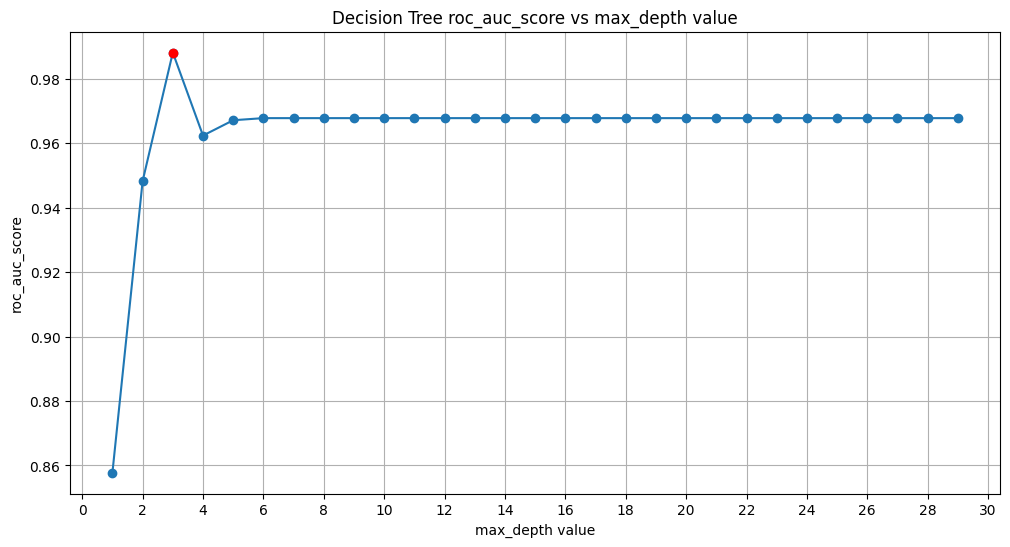

In [245]:
decision_tree_roc_auc_score = []

for max_depth_value in range(1,30):
    decision_tree_classifier = DecisionTreeClassifier(max_depth=max_depth_value)
    decision_tree_classifier.fit(x_train,y_train)

    roc_auc, fpr, tpr = OvR_micro_averaged_ROC_curve(decision_tree_classifier, x_test, y_test, np.unique(y))
    decision_tree_roc_auc_score.append(roc_auc["micro"])

decision_tree_best_max_depth_parameter = np.argmax(decision_tree_roc_auc_score) + 1
print("Best max_depth parameter:", decision_tree_best_max_depth_parameter)

plt.figure(figsize=(12,6))
plt.plot(range(1,30), decision_tree_roc_auc_score, marker="o")
plt.plot(decision_tree_best_max_depth_parameter, decision_tree_roc_auc_score[decision_tree_best_max_depth_parameter-1], "o", c="red")
plt.locator_params(axis="x", nbins=30) 
plt.title("Decision Tree roc_auc_score vs max_depth value")
plt.xlabel("max_depth value")
plt.ylabel("roc_auc_score")
plt.grid()

##### 3.2.2. Conducting the Decision Tree Classification

In [246]:
decision_tree_classifier = DecisionTreeClassifier(
    max_depth=decision_tree_best_max_depth_parameter
).fit(x_train,y_train)

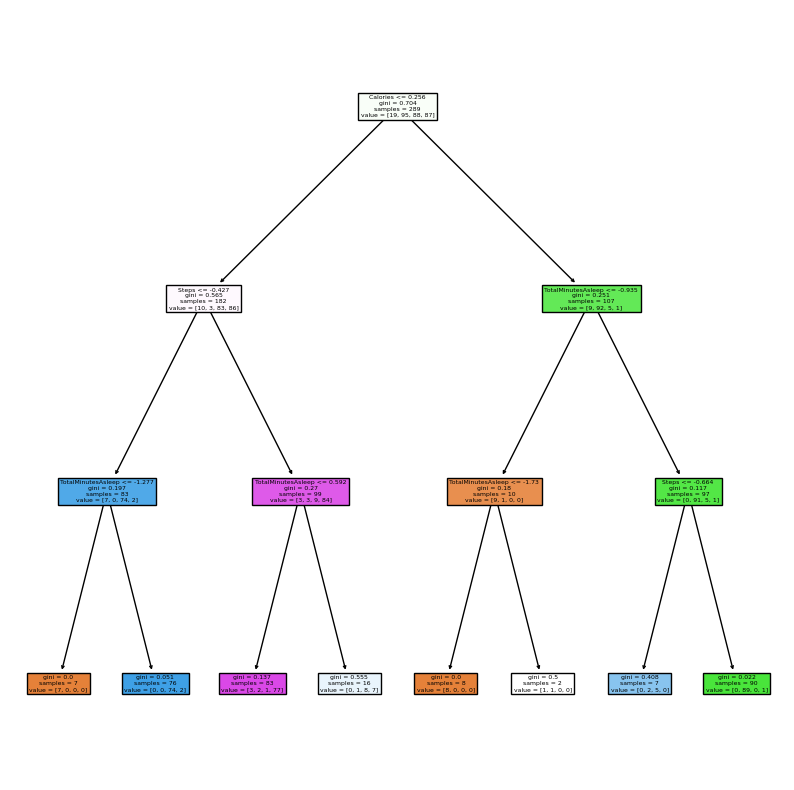

In [247]:
plt.figure(figsize = (10,10))
plot_tree(
    decision_tree_classifier, 
    feature_names=x_train.columns, 
    filled=True
)
plt.show()

##### 3.2.3. Decision Tree ROC-curve

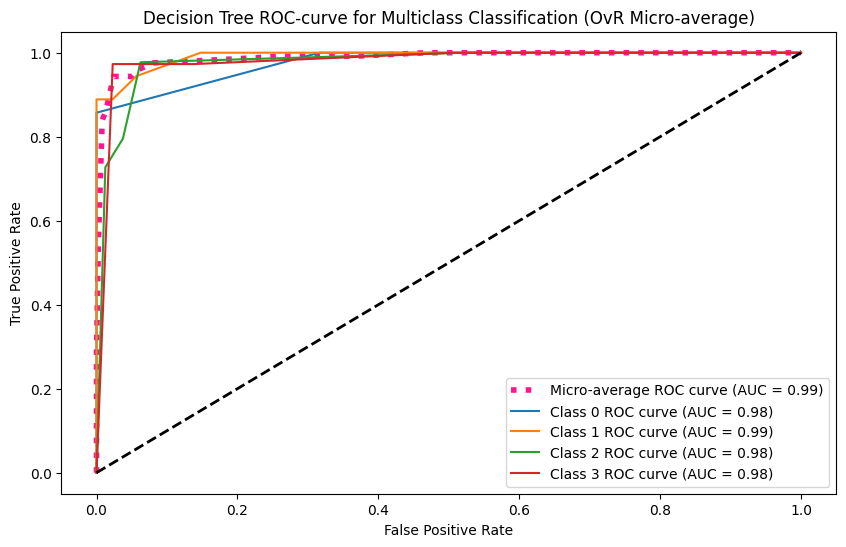

In [248]:
roc_auc, fpr, tpr = OvR_micro_averaged_ROC_curve(decision_tree_classifier, x_test, y_test, np.unique(y))
decision_tree_roc_auc_score = roc_auc["micro"]

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color="deeppink", linestyle=":", linewidth=4)

for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC-curve for Multiclass Classification (OvR Micro-average)")
plt.legend(loc="lower right")
plt.show()

##### 3.2.4. Confusion Matrix

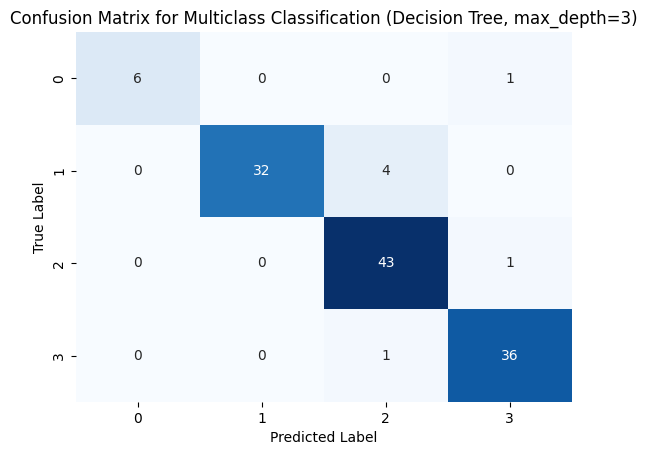

In [249]:
decision_tree_confusion_matrix = confusion_matrix(y_test, decision_tree_classifier.predict(x_test))

# Plot the confusion matrix using seaborn
sns.heatmap(decision_tree_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for Multiclass Classification (Decision Tree, max_depth={decision_tree_best_max_depth_parameter})")
plt.show()

##### 3.2.5. Decision Tree Prediction

In [250]:
pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = decision_tree_classifier.predict(input_data)[0]

decision_tree_classifier_prediction = pure_input_data
decision_tree_classifier_prediction["FitnessGroup"] = output_data
decision_tree_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,FitnessGroup
0,1797,10735,384.0,3


#### 3.3. Naive Bayes Classifier

##### 3.3.1. Adjusting step (postponed)

##### 3.3.2. Conducting the Naive Bayes Classification 

In [251]:
naive_bayes_classifier = GaussianNB().fit(x_train,y_train)

##### 3.3.3. Naive Bayes ROC-curve

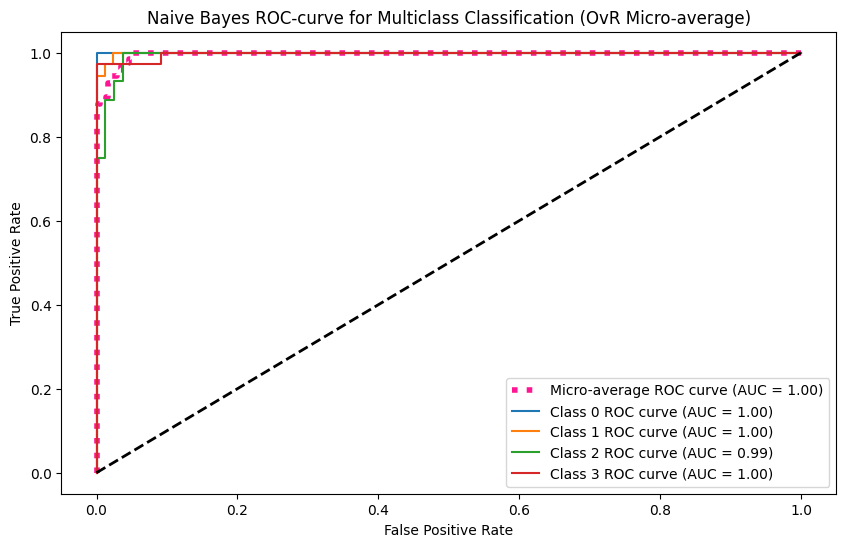

In [252]:
roc_auc, fpr, tpr = OvR_micro_averaged_ROC_curve(naive_bayes_classifier, x_test, y_test, np.unique(y))
naive_bayes_roc_auc_score = roc_auc["micro"]

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color="deeppink", linestyle=":", linewidth=4)

for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes ROC-curve for Multiclass Classification (OvR Micro-average)")
plt.legend(loc="lower right")
plt.show()

##### 3.3.4. Confusion Matrix

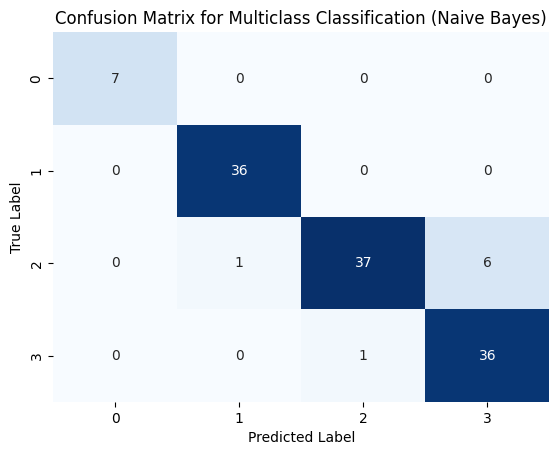

In [253]:
naive_bayes_confusion_matrix = confusion_matrix(y_test, naive_bayes_classifier.predict(x_test))

# Plot the confusion matrix using seaborn
sns.heatmap(naive_bayes_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for Multiclass Classification (Naive Bayes)")
plt.show()

##### 3.3.5. Naive Bayes Prediction

In [254]:
pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = naive_bayes_classifier.predict(input_data)[0]

naive_bayes_classifier_prediction = pure_input_data
naive_bayes_classifier_prediction["FitnessGroup"] = output_data
naive_bayes_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,FitnessGroup
0,1797,10735,384.0,3


#### 3.4. XGBoost Classifier

##### 3.4.1. Adjusting max_depth parameter

Best max_depth parameter: 4


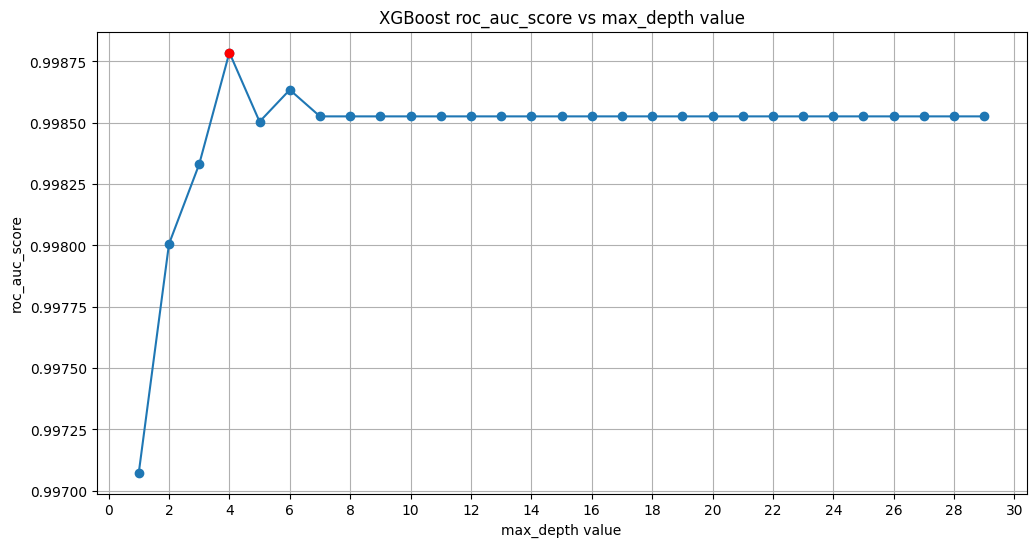

In [255]:
xgboost_roc_auc_score = []

for max_depth_value in range(1,30):
    xgboost_classifier = XGBClassifier(max_depth=max_depth_value)
    xgboost_classifier.fit(x_train,y_train)

    roc_auc, fpr, tpr = OvR_micro_averaged_ROC_curve(xgboost_classifier, x_test, y_test, np.unique(y))
    xgboost_roc_auc_score.append(roc_auc["micro"])

xgboost_best_max_depth_parameter = np.argmax(xgboost_roc_auc_score) + 1
print("Best max_depth parameter:", xgboost_best_max_depth_parameter)

plt.figure(figsize=(12,6))
plt.plot(range(1,30), xgboost_roc_auc_score, marker="o")
plt.plot(xgboost_best_max_depth_parameter, xgboost_roc_auc_score[xgboost_best_max_depth_parameter-1], "o", c="red")
plt.locator_params(axis="x", nbins=30) 
plt.title("XGBoost roc_auc_score vs max_depth value")
plt.xlabel("max_depth value")
plt.ylabel("roc_auc_score")
plt.grid()

##### 3.4.2. Conducting the XGBoost Classification 

In [256]:
xgboost_classifier = XGBClassifier(
    max_depth=xgboost_best_max_depth_parameter
).fit(x_train,y_train)

##### 3.4.3. XGBoost ROC-curve

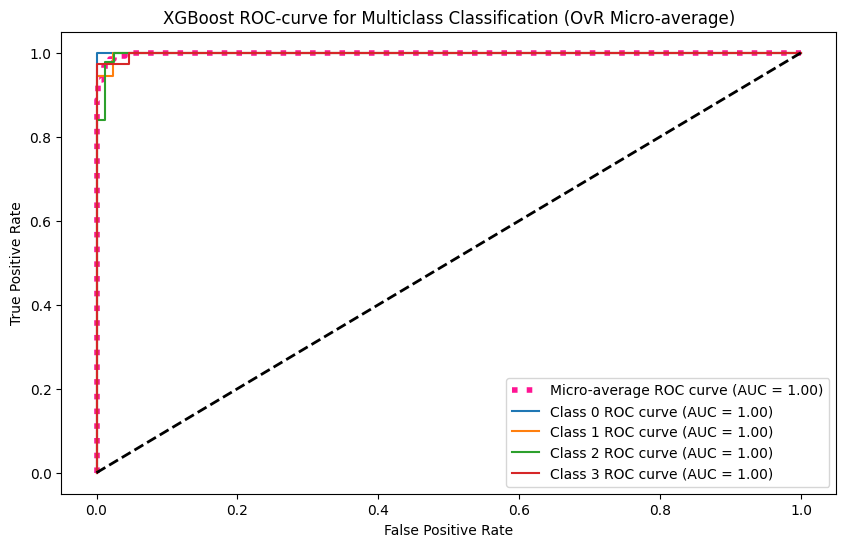

In [257]:
roc_auc, fpr, tpr = OvR_micro_averaged_ROC_curve(xgboost_classifier, x_test, y_test, np.unique(y))
xgboost_roc_auc_score = roc_auc["micro"]

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color="deeppink", linestyle=":", linewidth=4)

for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC-curve for Multiclass Classification (OvR Micro-average)")
plt.legend(loc="lower right")
plt.show()

##### 3.4.4. Confusion Matrix

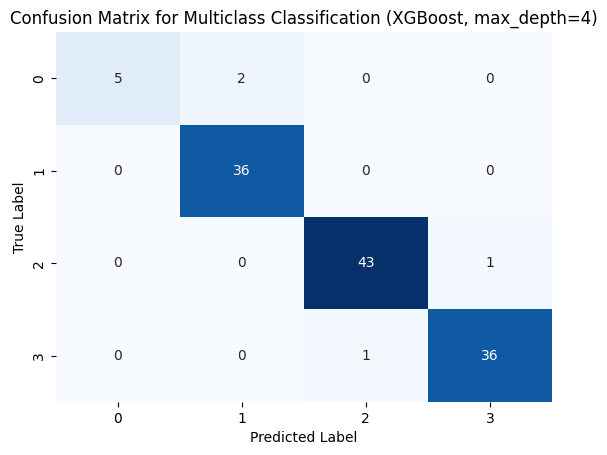

In [258]:
xgboost_confusion_matrix = confusion_matrix(y_test, xgboost_classifier.predict(x_test))

# Plot the confusion matrix using seaborn
sns.heatmap(xgboost_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for Multiclass Classification (XGBoost, max_depth={xgboost_best_max_depth_parameter})")
plt.show()

##### 3.4.5. XGBoost Prediction

In [259]:
pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = xgboost_classifier.predict(input_data)[0]

xgboost_classifier_prediction = pure_input_data
xgboost_classifier_prediction["FitnessGroup"] = output_data
xgboost_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,FitnessGroup
0,1797,10735,384.0,3


#### 4. Choosing The Best Model

##### 4.1. ROC-AUC Scores

In [260]:
classification_roc_auc_score = pd.DataFrame({
    "KNN": [knn_roc_auc_score],
    "Decision Tree": [decision_tree_roc_auc_score],
    "Naive Bayes": [naive_bayes_roc_auc_score],
    "XGBoost": [xgboost_roc_auc_score],

})

classification_roc_auc_score.index = ["ROC AUC score (max is better)"]
classification_roc_auc_score

,KNN,Decision Tree,Naive Bayes,XGBoost
ROC AUC score (max is better),0.997193,0.988077,0.996683,0.998786


##### 4.2. Cross-Validation (scoring="f1_weighted")

In a multiclass classification problem, you often have multiple classes, and the F1 score can be computed for each class separately. The weighted F1 score takes into account the class imbalance by computing the average of the F1 scores, where each class's score is weighted by the number of samples in that class.

In [261]:
cv_splitter = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42) # n_splits = 10 specifies 10-fold cross-validation

knn_scores = cross_val_score(knn_classifier, x, y, scoring="f1_weighted", cv=cv_splitter) 
decision_tree_scores = cross_val_score(decision_tree_classifier, x, y, scoring="f1_weighted", cv=cv_splitter)
naive_bayes_scores = cross_val_score(naive_bayes_classifier, x, y, scoring="f1_weighted", cv=cv_splitter)
xgboost_scores = cross_val_score(xgboost_classifier, x, y, scoring="f1_weighted", cv=cv_splitter)

classification_cross_validation_score = pd.DataFrame({
    "KNN": [np.mean(knn_scores)],
    "Decision Tree": [np.mean(decision_tree_scores)],
    "Naive Bayes": [np.mean(naive_bayes_scores)],
    "XGBoost": [np.mean(xgboost_scores)],
})

classification_cross_validation_score.index = ["Average cross-val. score (max is better)"]
classification_cross_validation_score

,KNN,Decision Tree,Naive Bayes,XGBoost
Average cross-val. score (max is better),0.967147,0.89849,0.943054,0.958429


#### 5. Save & Reuse The Best Model (XGBoost)

In [262]:
# Save the trained model to a file
model_filename = "FitnessGroup_xgboost_classifier.joblib"
joblib.dump(xgboost_classifier, model_filename)
print(f"Trained model saved as '{model_filename}'")

Trained model saved as 'FitnessGroup_xgboost_classifier.joblib'


In [263]:
# Let's try to load the model and make predictions
loaded_classifier = joblib.load("FitnessGroup_xgboost_classifier.joblib")

# Load the scaler from the file
loaded_scaler = joblib.load("scaler_classification.joblib")

pure_input_data = pd.DataFrame({
    "Calories": [1797], 
    "Steps": [10735], 
    "TotalMinutesAsleep": [384.0]
})

# Use the scaler to transform new data
input_data = pd.DataFrame(loaded_scaler.transform(pure_input_data), columns=pure_input_data.columns)

output_data = loaded_classifier.predict(input_data)[0]

loaded_classifier_prediction = pure_input_data
loaded_classifier_prediction["FitnessGroup"] = output_data
loaded_classifier_prediction

,Calories,Steps,TotalMinutesAsleep,FitnessGroup
0,1797,10735,384.0,3
